### Analayses of Pangu idealized P3 pert experiment initialized with NDJF climo 

**Products**: Fig. 2

In [1]:
import glob
import os
import io
import numpy as np
import xarray as xr
# import gcsfs

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as patches
import cartopy.crs as ccrs
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import FormatStrFormatter
from PIL import Image
from matplotlib.backends.backend_pdf import PdfPages
import cartopy.feature as cfeature
import matplotlib.patches as mpatches # add polygon
from matplotlib.transforms import Bbox


In [2]:
def find_files(path, keyword):
    # Create search pattern for the file names
    files = glob.glob(path + '/' + keyword)  # List of files matching the pattern
    return len(files) > 0  # Check if any files were found

In [3]:
def save_netcdf_pangu(path, case_name):
    '''
    convert npy outputs to netcdf files
    '''
    
    varnames_srf = ['msl', 'u10', 'v10', 't2m']
    varnames_plv = ['z', 'q', 't', 'u', 'v']
    fpath = path 
    print(fpath)

    d0 = xr.open_dataset('/barnes-engr-scratch1/dcr17/Pangu_experiments/idealized_T_ens/ERA5/Pangu_coordinates.nc')
    lat = d0.latitude
    lon = d0.longitude
    plev = d0.plev

    #===== include input file
    total_days = int(len(glob.glob(fpath + '*srf*.npy')))
    time = np.arange(total_days)

    #===== surface =====#
    print('read surface data....')
    for varname in varnames_srf:
        print('reading ' + varname)
        print(str(total_days) + ' days in total')
        count = 0
        for day in range(total_days):
            # print('loading day:' + str(day) + ' (' + str(total_days) + ' days in total)')

            fname_srf = glob.glob(fpath + '*srf*day' + str(day) + '.npy')
            ds = np.load(fname_srf[0])
            v_temp = ds[varnames_srf.index(varname)]

            if day == 0:
                v = np.expand_dims(v_temp, axis=0)
                v = np.tile(v, (total_days, 1, 1))
                v[1:,] = np.nan
            else:
                v[count, ] = v_temp
            
            count += 1

        #===== create xarray dataarray =====#
        v = xr.DataArray(v,
                         dims=['time', 'latitude', 'longitude'],
                         coords = {'time': time,
                                   'latitude': lat,
                                   'longitude': lon
                         },
                         attrs = d0[varname].attrs
        )
        
        #===== save to netcdf =====#
        v = v.to_dataset(name = varname)
        v.to_netcdf(fpath + 'output_srf.' + case_name + '.' + varname + '.day0-' + str(total_days-1) + '.nc')
        
        del ds, fname_srf, v_temp

    
    #===== upper =====#
    print('read upper data....')
    for varname in varnames_plv:
        print('reading ' + varname)
        print(str(total_days) + ' days in total)')
        count = 0
        for day in range(total_days):

            fname_upper = glob.glob(fpath + '*upper*day' + str(day) + '.npy')
            ds = np.load(fname_upper[0])
            v_temp = ds[varnames_plv.index(varname)]

            if day == 0:
                v = np.expand_dims(v_temp, axis=0)
                v = np.tile(v, (total_days, 1, 1, 1))
                v[1:,] = np.nan
            else:
                v[count, ] = v_temp
            
            count += 1

        #===== create xarray dataarray =====#
        v = xr.DataArray(v,
                         dims=['time', 'plev', 'latitude', 'longitude'],
                         coords = {'time': time,
                                   'plev': plev,
                                   'latitude': lat,
                                   'longitude': lon
                         },
                         attrs = d0[varname].attrs
        )
        
        #===== save to netcdf =====#
        v = v.to_dataset(name = varname)
        if path == '/barnes-engr-scratch1/dcr17/Pangu_experiments/idealized_T_ens/climo_runs/output/':
            v.to_netcdf(fpath + 'output_upper.' + case_name + '-climo_1980-2023.' + varname + '.day0-' + str(total_days-1) + '.nc')
        else:
            v.to_netcdf(fpath + 'output_upper.' + case_name + '.' + varname + '.day0-' + str(total_days-1) + '.nc')
        
        del ds, fname_upper, v_temp




In [4]:
def load_outputs(path, case_name, vname):
    '''
    load outputs from netcdf files;
    if netcdf files do not exit, create them 1st by calling postprocess func
    '''

    #===== create netcdf files =====#
    opath = path
    if not find_files(opath, '*.nc'):
        print('netcdf files for ' + case_name + ' do not exist, creating them now...')
        save_netcdf_pangu(path, case_name)
    else:
        print('read netcdf files...')
        
    #===== read netcdf files  =====#  
    f = glob.glob(opath + '*.' + vname + '.*.nc')
    print(f)
    ds = xr.open_dataset(f[0])
    v = ds[vname]

    return v


In [5]:
def process_case(exp_name, varname, plev=0):
    '''
    exp_name: ['P3_pert_1K_steady', 'P3_pert_01K_steady', 'P3_pert_1K_traditional', 'P3_pert_01K_traditional']
    '''
    #========== read exp data ==========#
    
    path = '../' + exp_name + '/output/'
    case_name = f'MJO_{exp_name}'  

    if varname in ['z']:
        g = 9.8
        v = load_outputs(path, case_name, varname).sel(plev=plev) /g
        v.attrs['units'] = 'm'
    else:
        v = load_outputs(path, case_name, varname)

    return v

In [6]:
def load_climo(path, case_name, vname):
    '''
    load outputs from netcdf files;
    if netcdf files do not exit, create them 1st by calling postprocess func
    '''

    #===== create netcdf files =====#
    opath = path + case_name + '/'
    if not find_files(opath, '*.nc'):
        print('netcdf files for ' + case_name + ' do not exist, creating them now...')
        save_netcdf_pangu(path, case_name)
    else:
        print('read netcdf files...')
        
    #===== read netcdf files  =====#  
    f = glob.glob(opath + '*' + vname + '*.nc')
    ds = xr.open_dataset(f[0])
    v = ds[vname]

    return v

In [9]:
def delta_T_MJO_P3(lat, lon, plev, A=1):
    '''
    calculate MJO phase 3 idealized temperature perturbation
    A: peak heating rate at 0.35 sigma level
    '''
    # parameters for MJO phase 3
    lon_1 = 90 # center of forcing 1
    lon_2 = 170 # center of forcing 2
    #lat_1, lat_2 = 0
    
    lon_scale = 30 # longitude scale; 0.2*A at 50ºE
    lat_scale = 12 # latitude scale; ~0.2*A at 15ºN

    # vertical spread
    P0 = 1000.0 # set surface plev
    v_sprd_max = 0.57923
    sigma = plev / P0
    v_sprd = (1 - sigma) * np.sin( np.pi * (1 - sigma) ) / v_sprd_max

    # horizontal spread
    lat_sprd = np.exp(-1 * (lat/lat_scale)**2)
    term1 = np.exp(-1 * ((lon - lon_1)/lon_scale)**2)
    # term2 = np.exp(-1 * ((lon - lon_2)/lon_scale)**2)
    # h_sprd = np.exp(-1 * (lat/lat_scale)**2) * (term1 - term2)
    h_sprd = np.exp(-1 * (lat/lat_scale)**2) * term1

    h_sprd = h_sprd.where(np.abs(h_sprd) >=0.1, np.nan)


    # pert
    delta_T =  A * v_sprd * h_sprd
    return delta_T

In [7]:
def plot_heating_map(ax, lat, lon, A=1.0):

    plev = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]
    plev = xr.DataArray(plev,
                        coords = dict(plev=plev),
                        attrs=dict(
                            long_name = 'pressure level', 
                            units = 'hPa'
                        ))
    
    d_T = delta_T_MJO_P3(lat, lon, plev, A=1.0)

    ax.coastlines()
    # ax.gridlines(draw_labels=True)

    contour_levels = list(np.arange(-1*A, 1.09 *A, A/10))

    contour = ax.contourf(d_T.longitude, d_T.latitude, d_T.sel(plev=300), transform=ccrs.PlateCarree(), 
                        cmap='RdBu_r', extend='neither', levels=contour_levels, vmin=-1*A, vmax=1.01 *A)

    # Add a color bar
    cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, aspect=20, shrink=0.6, label='K/day')
    cbar.ax.tick_params(labelsize=8)

    # Set the title
    ax.set_title("(a) Idealized heating", loc='center', fontsize=15)


In [8]:
def plot_heating_vertical_profile(ax, lat, lon, A=1.0):

    plev = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]
    plev = xr.DataArray(plev,
                        coords = dict(plev=plev),
                        attrs=dict(
                            long_name = 'pressure level', 
                            units = 'hPa'
                        ))
    d_T = delta_T_MJO_P3(lat, lon, plev, A=1.0)
    d_T_max = d_T.sel(latitude=0, longitude=90)

    ax.plot(d_T_max, d_T.plev, linewidth=2, c= 'k')
    ax.invert_yaxis()
    ax.set_yticks(d_T_max.plev)
    ax.set_xlabel('K/day', fontsize=10)
    ax.set_ylabel('Pressure level (hPa)', fontsize=10)
    ax.set_title('(b) Vertical Profile', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=10)

In [10]:
def plot_z500(fig, ax, z500, title, vlim=0, add_heating_loc=True):
        
    ax.set_global()
    ax.coastlines()
    # ax.gridlines(draw_labels=True)

    ax.set_title('')
    ax.set_title(title, loc='center', fontsize=15)

    #=====  set colorbar limits =====#
    if vlim == 0:
        if z500.latitude[0] < -45:
            vmax = round(float(z500.sel(latitude=slice(-60, 60)).max()) * 1.2)
        else:
            vmax = round(float(z500.sel(latitude=slice(60, -60)).max()) * 1.2)
        vmin = -1*vmax
    else:
        vmax = vlim
        vmin = -1.0 * vmax
    contour_levels = list(np.arange(vmin, vmax*1.01, vmax/20))

    cmap = plt.get_cmap('bwr', 256)
    #===== plot contourf =====#
    contour = ax.contourf(z500.longitude, z500.latitude, z500,  transform=ccrs.PlateCarree(),
                          cmap=cmap, extend='both', levels=contour_levels, vmin=vmin, vmax=vmax)

    #===== add individual colorbar =====#   
    cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, aspect=20, shrink=0.6, label='m')
    cbar.ax.tick_params(labelsize=10)
    cbar.locator = LinearLocator(numticks=5)  # You can change nbins to 4, 6, etc.
    cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # or '%.0f' for integers
    cbar.update_ticks() 

    #===== add heating loc =====#
    if add_heating_loc == True:
        lat_scale = 15  # Latitude scale (semi-minor axis)
        lon_scale = 40  # Longitude scale (semi-major axis)
        lon_c = 90
        lat_c = 0
        ellipse = patches.Ellipse((lon_c, lat_c), width=lon_scale*2, height=lat_scale*2, 
                                    edgecolor='r', facecolor='none', linestyle='--', lw=2, transform=ccrs.PlateCarree())
        ax.add_patch(ellipse)  



def plot_panel(z500_diff, climo, model_name, case, vlims=False, add_heating_loc=True, plot_heating=True, fig_name=False):
    #========== plot t2m diff ==========#
    # Set up the map projection (PlateCarree centered at 180° longitude)
    # proj = ccrs.PlateCarree(central_longitude=180)
    proj = ccrs.Robinson(central_longitude=180) 
    if plot_heating:
        fig, axes = plt.subplots(3, 2, figsize=(10, 10), subplot_kw={'projection': proj})
    else:
        fig, axes = plt.subplots(2, 2, figsize=(10, 6.67), subplot_kw={'projection': proj},)

    panel_num = ['(a) ', '(b) ', '(c) ', '(d) ', '(e) ', '(f) ', ]

    count_wk = 0

    for i, ax in enumerate(axes.flat):
        print(i)
        
        #===== plot heating schematic =====#
        if i == 0 and plot_heating:
            print('plot heating')
            lat = climo.latitude
            lon = climo.longitude
            plot_heating_map(ax, lat, lon, A=1.0)
        
        elif i == 1 and plot_heating:
            print('plot heating vertical profile')
            fig.delaxes(ax)
            ax = fig.add_subplot(3, 2, i + 1)  # i + 1 is the subplot index (1-based)
            axes.flat[i] = ax  # replace in array to preserve consistency
            box = ax.get_position()
            new_width = box.width * 0.6
            new_height = box.height * 0.85
            new_x = box.x0 + (box.width - new_width) *0.5
            new_y = box.y0 + (box.height - new_height)
            new_box = Bbox.from_bounds(new_x, new_y, new_width, new_height)
            ax.set_position(new_box)

            lat = climo.latitude
            lon = climo.longitude
            plot_heating_vertical_profile(ax, lat, lon, A=1.0)

        else:
            
            ax.set_global()
            ax.coastlines()
            # ax.gridlines(draw_labels=True)

            #===== set title =====#
            if count_wk == 0:
                title = rf'{panel_num[i]} $\mathbf{{{model_name}}}$: Week 1'
            else:
                title = f'{panel_num[i]} Week {count_wk+1}' 

            #===== plot z550a =====#
            v_temp = z500_diff.sel(time=slice(7*count_wk+1, 7*(count_wk+1)+1)).mean(dim='time')
            vlim = vlims[count_wk] if vlims else 0
            plot_z500(fig, ax, v_temp, title, vlim=vlim, add_heating_loc=add_heating_loc)
            count_wk += 1

    #===== save to png =====#
    if fig_name:

        print(f'saving figure to {fig_name}')
        
        #===== adjust brightness =====#
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight', dpi=400)
        buf.seek(0)
        image = Image.open(buf).convert('RGB')
        bright_image = Image.eval(image, lambda x: min(int(x * 1.07), 255))  # 1.2 = brighten factor
        plt.figure(figsize=(20, 10))
        plt.imshow(bright_image)
        plt.axis('off')

        save_path = '/barnes-engr-scratch1/dcr17/PROJ_DLWP_and_MJO-teleconnection/analy/figs'
        plt.savefig(f'{save_path}/{fig_name}.png', dpi=400)  # Save as PNG with 300 DPI
        plt.show()

    else:

        plt.suptitle(case, fontsize=15)
        plt.show()

## Main

In [11]:
#===== create case files: P3_pert_1K_steady_NDJF_climo =====#

exp_name = 'P3_pert_1K_steady_NDJF-climo'
z500 = process_case(exp_name, 'z', plev=500)

read netcdf files...
['../P3_pert_1K_steady_NDJF-climo/output/output_upper.MJO_P3_pert_1K_steady.z.day0-25.nc']


In [12]:
#===== create case files: P3_pert_01K_steady_NDJF-climo_decay-5d =====#

exp_name = 'P3_pert_01K_steady_NDJF-climo_decay-5d'
z500_decay = process_case(exp_name, 'z', plev=500)

read netcdf files...
['../P3_pert_01K_steady_NDJF-climo_decay-5d/output/output_upper.MJO_P3_pert_01K_steady_NDJF-climo_decay-5d.z.day0-30.nc']


In [13]:
#===== create case files: P3_pert_01K_steady_NDJF-climo_not-remove-tendency =====#

exp_name = 'P3_pert_1K_steady_NDJF-climo_not-remove-tendency'
z500_full = process_case(exp_name, 'z', plev=500)

read netcdf files...
['../P3_pert_1K_steady_NDJF-climo_not-remove-tendency/output/output_upper.MJO_P3_pert_1K_steady_NDJF-climo_not-remove-tendency.z.day0-30.nc']


In [14]:
#===== load climo files =====#

exp_name = 'P3_pert_1K_steady_NDJF-climo'
path_climo = '/barnes-engr-scratch1/dcr17/Pangu_experiments/idealized_T_ens/climo_runs/output/'
case_name_climo = 'NDJF-climo'
z500_climo = load_climo(path_climo, case_name_climo, 'z').sel(plev=500)/9.8

read netcdf files...


#### plot

0
plot heating
1
plot heating vertical profile
2
3
4
5
saving figure to Fig_2


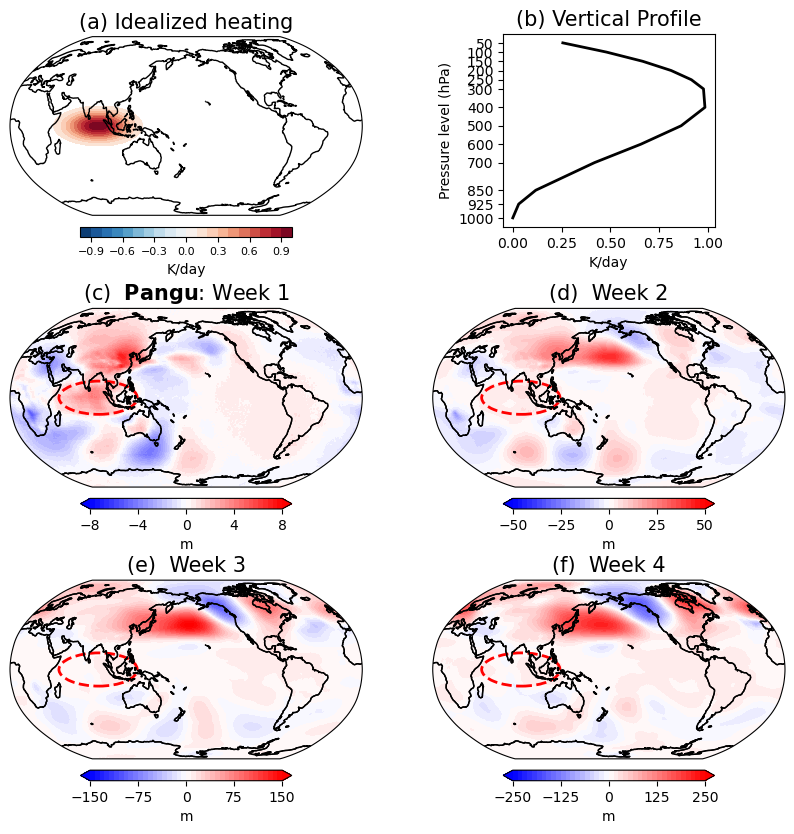

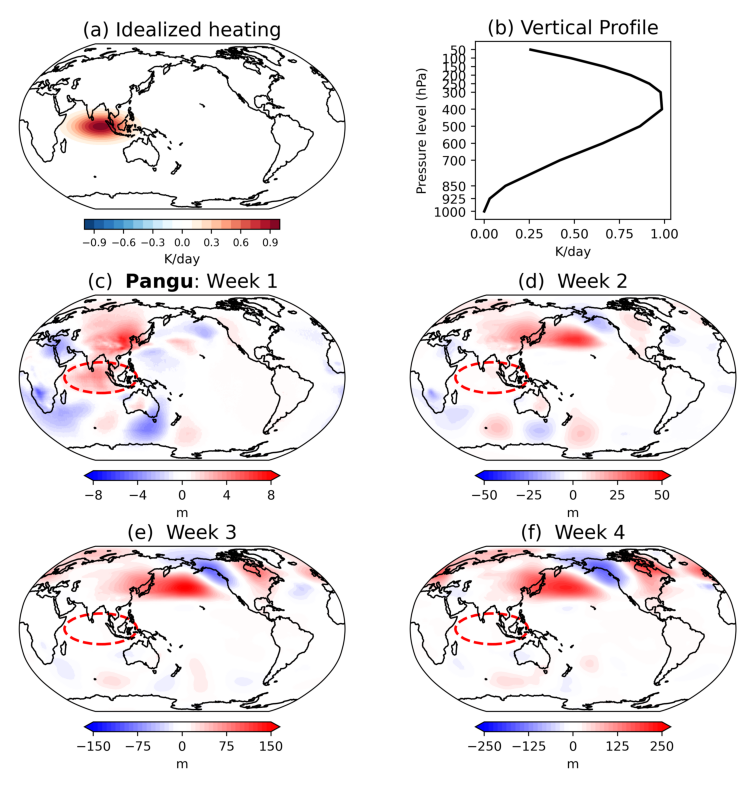

In [15]:
#===== plot z500 from 1K_steady_NDJF-climo =====#
exp_name = 'P3_pert_1K_steady_NDJF-climo'
diff = z500 - z500_climo[0]
plot_panel(diff,  z500_climo[0], 'Pangu', exp_name, vlims= [8, 50, 150, 250], add_heating_loc=True, plot_heating=True, fig_name='Fig_2')

0
plot heating
1
plot heating vertical profile
2
3
4
5
saving figure to Fig_S3


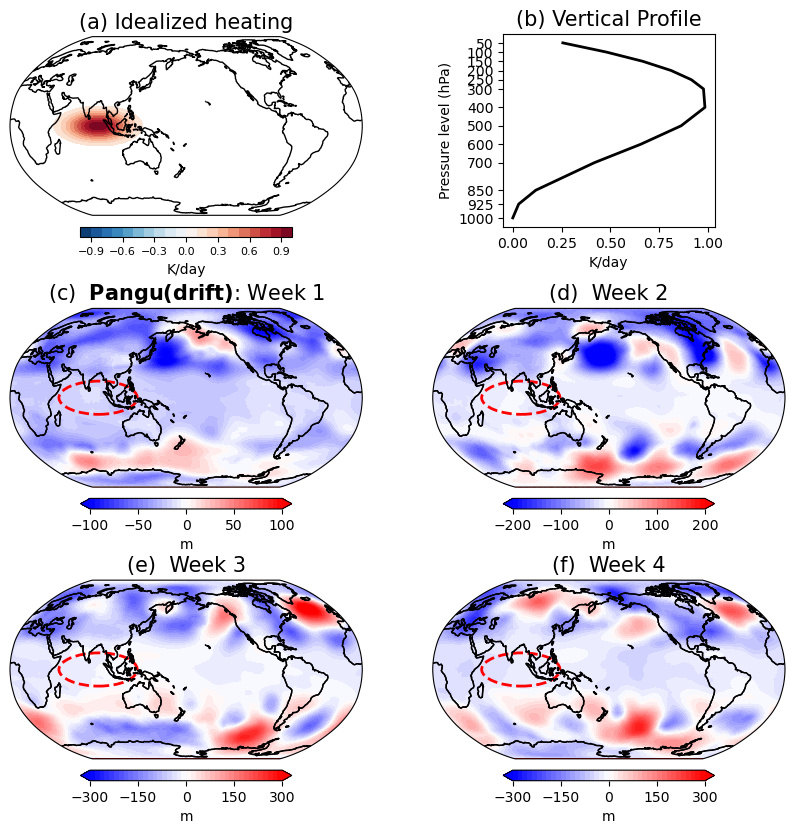

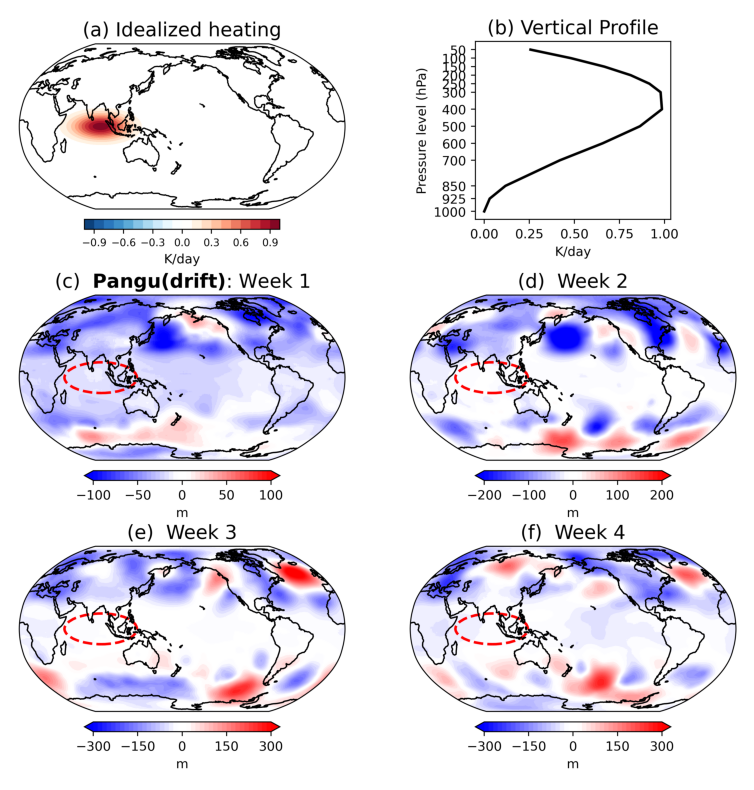

In [16]:
#===== plot z500 from 1K_steady_NDJF-climo =====#
exp_name = 'P3_pert_01K_steady_NDJF-climo_no-trend-removal'
diff = z500_full - z500_climo[0]
plot_panel(diff,  z500_climo[0], 'Pangu(drift)', exp_name, vlims= [100, 200, 300, 300], add_heating_loc=True, plot_heating=True, fig_name='Fig_S3')
